#FB Prophet implementation

**Data**: AAPL stock

**Granularity**: daily data

**Source**: Yahoo! Finance

**Time period**: 2010-01-04 / 2022-12-30

**Model**: FB Prophet


# Importing Packages

In [1]:
#Install Prophet library
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.metrics import mean_squared_error
from prophet import Prophet
from prophet.diagnostics import cross_validation

sns.set()

# Importing The Dataset

In [3]:
#Load the dataset
file_path = "/content/AAPL.csv"
data_backup = pd.read_csv(file_path)
data_backup.Date = pd.to_datetime(data_backup.Date)
data_backup.set_index("Date", inplace = True)

In [4]:
#Define log returns variable
log_returns = np.log(data_backup["Adj Close"]).diff(1) 
data_backup["log_returns"] = log_returns 

In [5]:
#Drop useless features
data = data_backup[["log_returns", "Adj Close"]]



# Train-Test Split

In [6]:
train_df = data.loc[:"2020-12-31"]
test_df = data.loc["2021-01-01":]
print(train_df.shape)
print(test_df.shape)

(2769, 2)
(503, 2)


# Building Prophet Models

## Returns

### Preparing Data for Prophet

In [7]:
#Reshape the dataset for fitting a Prophet model
returns_df = pd.DataFrame(columns = ["ds", "y"])
returns_df["ds"] = data.index
returns_df["y"] = data["log_returns"].values

In [8]:
returns_train_df = pd.DataFrame(columns = ["ds", "y"])
returns_train_df["ds"] = train_df.index
returns_train_df["y"] = train_df["log_returns"].values

In [9]:
returns_test_df = pd.DataFrame(columns = ["ds", "y"])
returns_test_df["ds"] = test_df.index
returns_test_df["y"] = test_df["log_returns"].values

### Fitting Model

In [10]:
returns_model = Prophet()
returns_model.fit(returns_train_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqsy8jcv/t9zg3zua.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqsy8jcv/hqifct_8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65782', 'data', 'file=/tmp/tmpoqsy8jcv/t9zg3zua.json', 'init=/tmp/tmpoqsy8jcv/hqifct_8.json', 'output', 'file=/tmp/tmpoqsy8jcv/prophet_model2n3ut9gf/prophet_model-20230525072340.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:23:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:23:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


### Making Predictions

In [11]:
future_df = returns_model.make_future_dataframe(periods=len(returns_test_df.index), freq = "D")

In [12]:
returns_predictions_df = returns_model.predict(future_df)

In [13]:
#Display predictions results
returns_predictions_df.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-01-04,0.001449,-0.017754,0.027870,0.001449,0.001449,0.003045,0.003045,0.003045,0.002621,0.002621,0.002621,0.000425,0.000425,0.000425,0.0,0.0,0.0,0.004495
1,2010-01-05,0.001449,-0.021050,0.025995,0.001449,0.001449,0.000849,0.000849,0.000849,0.000561,0.000561,0.000561,0.000289,0.000289,0.000289,0.0,0.0,0.0,0.002298
2,2010-01-06,0.001448,-0.020396,0.026265,0.001448,0.001448,0.000837,0.000837,0.000837,0.000720,0.000720,0.000720,0.000117,0.000117,0.000117,0.0,0.0,0.0,0.002286
3,2010-01-07,0.001448,-0.022057,0.021888,0.001448,0.001448,-0.001981,-0.001981,-0.001981,-0.001896,-0.001896,-0.001896,-0.000085,-0.000085,-0.000085,0.0,0.0,0.0,-0.000533
4,2010-01-08,0.001447,-0.024777,0.020608,0.001447,0.001447,-0.002594,-0.002594,-0.002594,-0.002283,-0.002283,-0.002283,-0.000311,-0.000311,-0.000311,0.0,0.0,0.0,-0.001147


### Plotting Forecasts and components

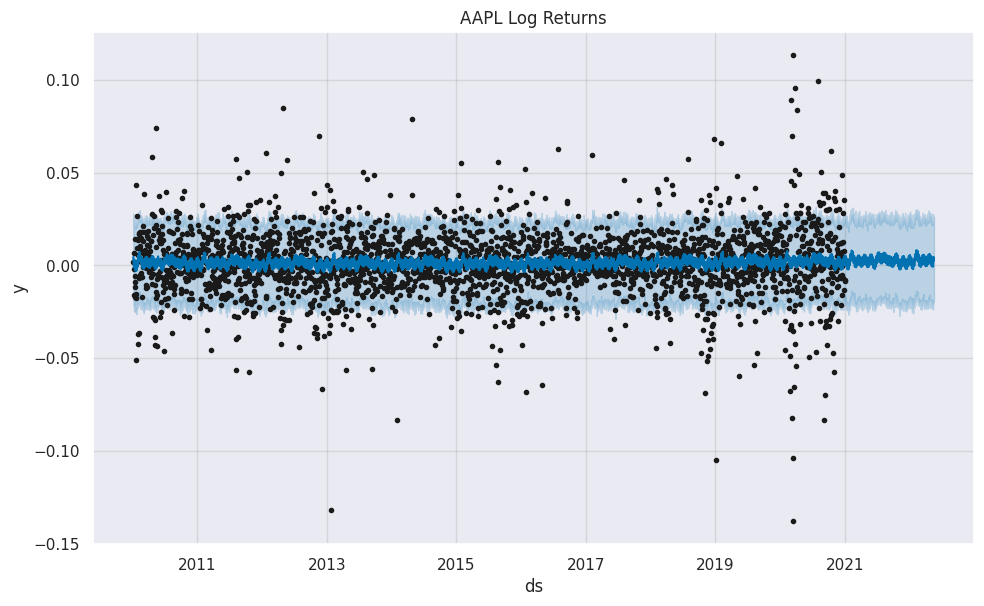

In [14]:
returns_model.plot(returns_predictions_df)
plt.title("AAPL Log Returns")
plt.show()

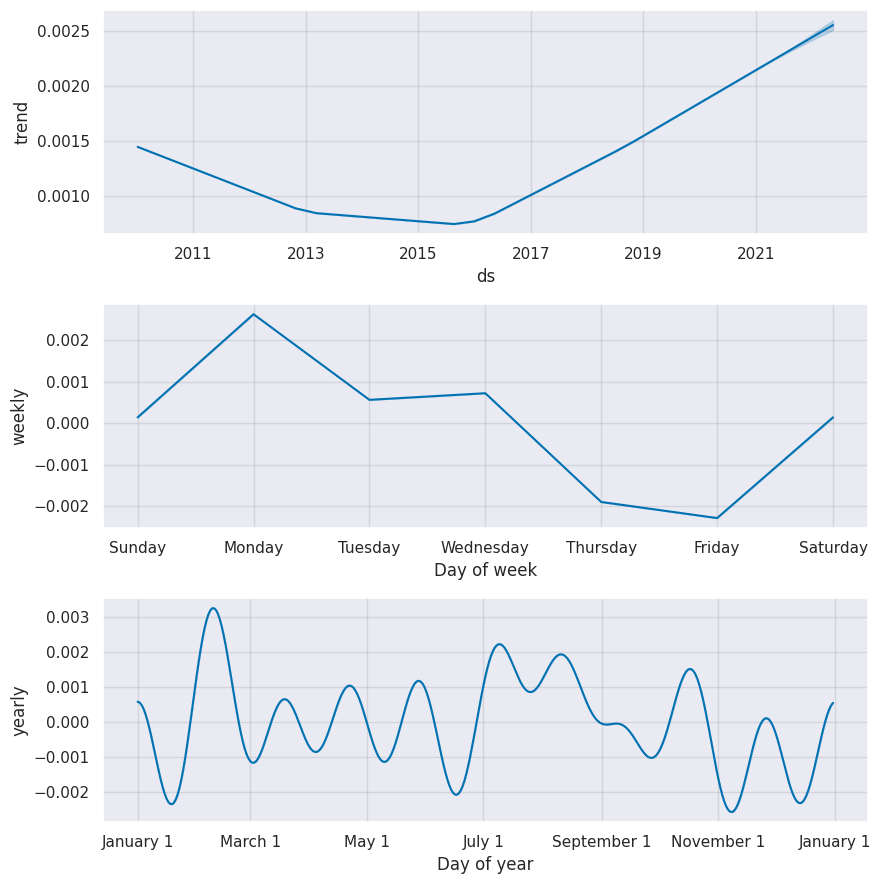

In [15]:
returns_model.plot_components(returns_predictions_df)
plt.show()

**Actual Weekly Seasonality**

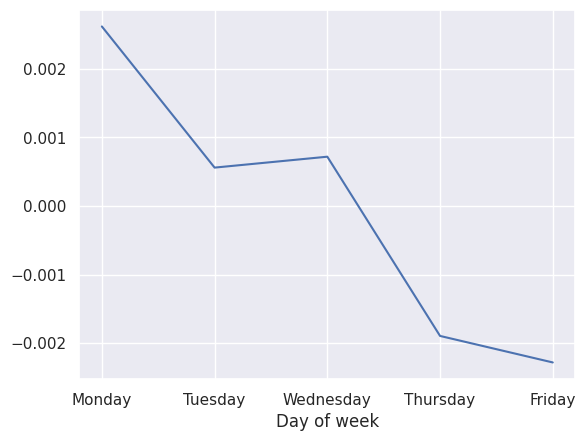

In [16]:
start_weekday = 0
while(True):
  if returns_predictions_df.ds[start_weekday].weekday() == 0:
    break
  else:
    start_weekday = start_weekday + 1

end_weekday = start_weekday + 5

days = returns_predictions_df.ds[start_weekday:end_weekday]
weekly_seas = returns_predictions_df.weekly[start_weekday:end_weekday]

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(np.arange(5), weekly_seas)
ax.set_xticks(np.arange(5))
ax.set_xticklabels(days.dt.day_name())
ax.set_xlabel('Day of week')

plt.show()

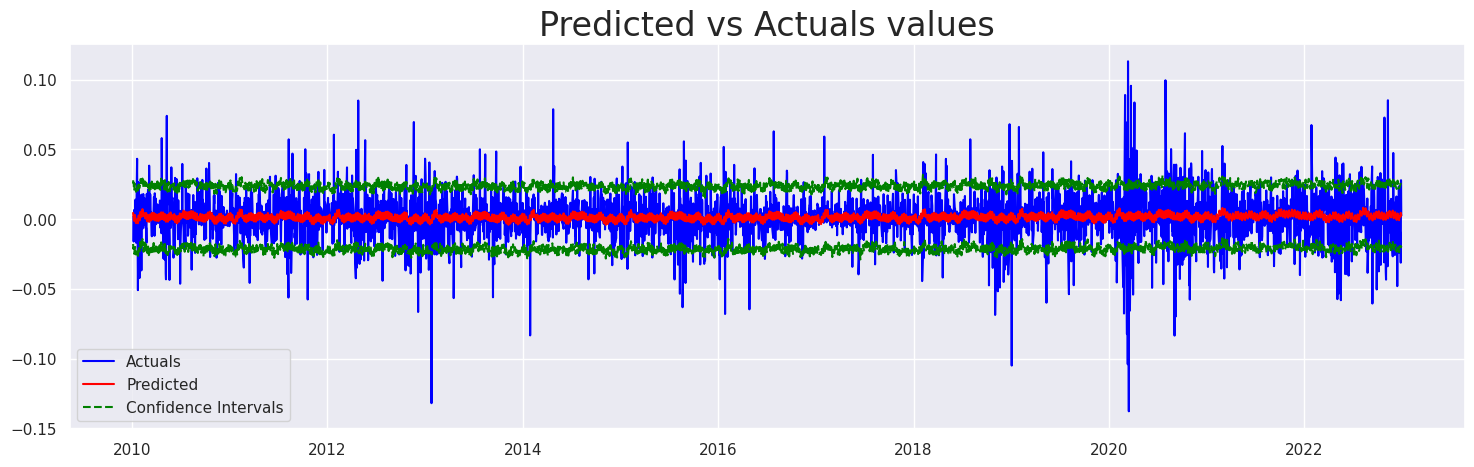

In [17]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(data["log_returns"], color = "blue", label = "Actuals")
plt.plot(data.index, returns_predictions_df["yhat"], color = "red", label = "Predicted")
plt.plot(data.index, returns_predictions_df["yhat_lower"], color = "green", linestyle = "--", label = "Confidence Intervals")
plt.plot(data.index, returns_predictions_df["yhat_upper"], color = "green", linestyle = "--")

plt.title("Predicted vs Actuals values", size = 24)

plt.legend()
plt.show()

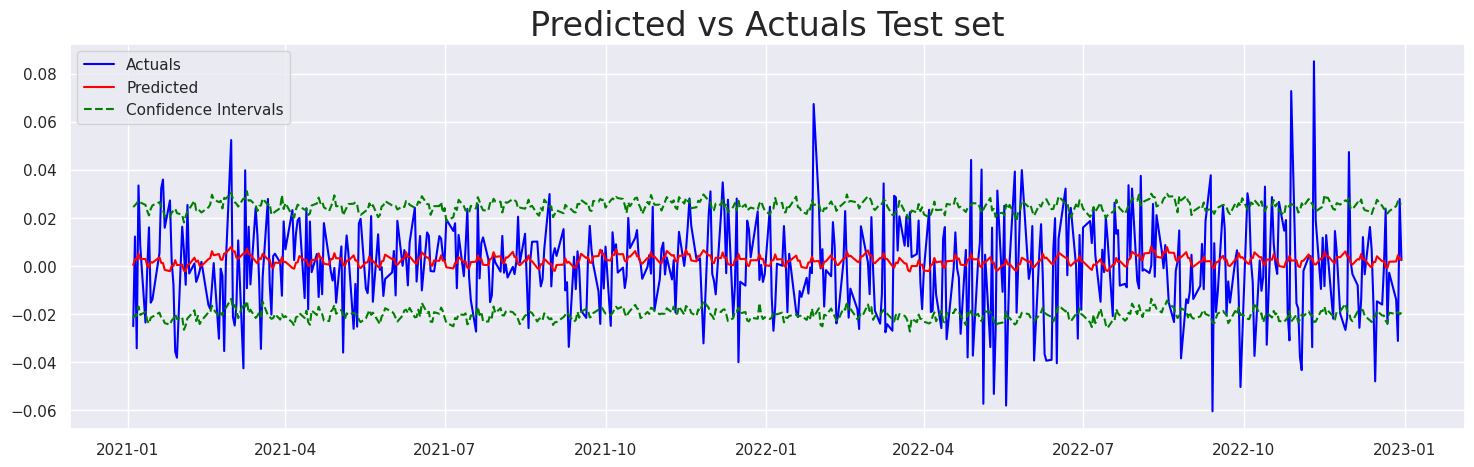

In [18]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(test_df["log_returns"], color = "blue", label = "Actuals")
plt.plot(test_df.index, returns_predictions_df.loc[returns_train_df.index[-1]+1:]["yhat"], color = "red", label = "Predicted")
plt.plot(test_df.index, returns_predictions_df.loc[returns_train_df.index[-1]+1:]["yhat_lower"], color = "green", linestyle = "--", label = "Confidence Intervals")
plt.plot(test_df.index, returns_predictions_df.loc[returns_train_df.index[-1]+1:]["yhat_upper"], color = "green", linestyle = "--")

plt.title("Predicted vs Actuals Test set", size = 24)

plt.legend()
plt.show()

### Accuracy

In [19]:
#Get the RMSE
y_true = returns_test_df["y"].values
y_pred = returns_predictions_df["yhat"][-len(returns_test_df.index):].values

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print("RMSE:", rmse)

RMSE: 0.019837167728444176


## Prices

### Preparing Data for Prophet

In [20]:
prices_df = pd.DataFrame(columns = ["ds", "y"])
prices_df["ds"] = data.index
prices_df["y"] = data["Adj Close"].values

In [21]:
prices_train_df = pd.DataFrame(columns = ["ds", "y"])
prices_train_df["ds"] = train_df.index
prices_train_df["y"] = train_df["Adj Close"].values

In [22]:
prices_test_df = pd.DataFrame(columns = ["ds", "y"])
prices_test_df["ds"] = test_df.index
prices_test_df["y"] = test_df["Adj Close"].values

### Fitting Model

In [23]:
prices_model = Prophet()
prices_model.fit(prices_train_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqsy8jcv/bwqpj93o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqsy8jcv/8qxuv5h5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13600', 'data', 'file=/tmp/tmpoqsy8jcv/bwqpj93o.json', 'init=/tmp/tmpoqsy8jcv/8qxuv5h5.json', 'output', 'file=/tmp/tmpoqsy8jcv/prophet_modelsbyiiijd/prophet_model-20230525072345.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:23:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:23:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


### Making Predictions

In [24]:
future_df = prices_model.make_future_dataframe(periods=len(prices_test_df.index), freq = "D")

In [25]:
prices_predictions_df = prices_model.predict(future_df)

In [26]:
prices_predictions_df.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-01-04,6.715878,0.107505,13.380010,6.715878,6.715878,-0.038063,-0.038063,-0.038063,0.045802,0.045802,0.045802,-0.083865,-0.083865,-0.083865,0.0,0.0,0.0,6.677815
1,2010-01-05,6.723738,-0.749691,13.187601,6.723738,6.723738,-0.125251,-0.125251,-0.125251,0.081999,0.081999,0.081999,-0.207250,-0.207250,-0.207250,0.0,0.0,0.0,6.598487
2,2010-01-06,6.731598,0.348917,13.508837,6.731598,6.731598,-0.213229,-0.213229,-0.213229,0.114935,0.114935,0.114935,-0.328165,-0.328165,-0.328165,0.0,0.0,0.0,6.518369
3,2010-01-07,6.739459,-0.420588,13.044560,6.739459,6.739459,-0.354077,-0.354077,-0.354077,0.091333,0.091333,0.091333,-0.445410,-0.445410,-0.445410,0.0,0.0,0.0,6.385382
4,2010-01-08,6.747319,-0.522532,13.195959,6.747319,6.747319,-0.615029,-0.615029,-0.615029,-0.057153,-0.057153,-0.057153,-0.557875,-0.557875,-0.557875,0.0,0.0,0.0,6.132290


### Plotting Forecasts and components

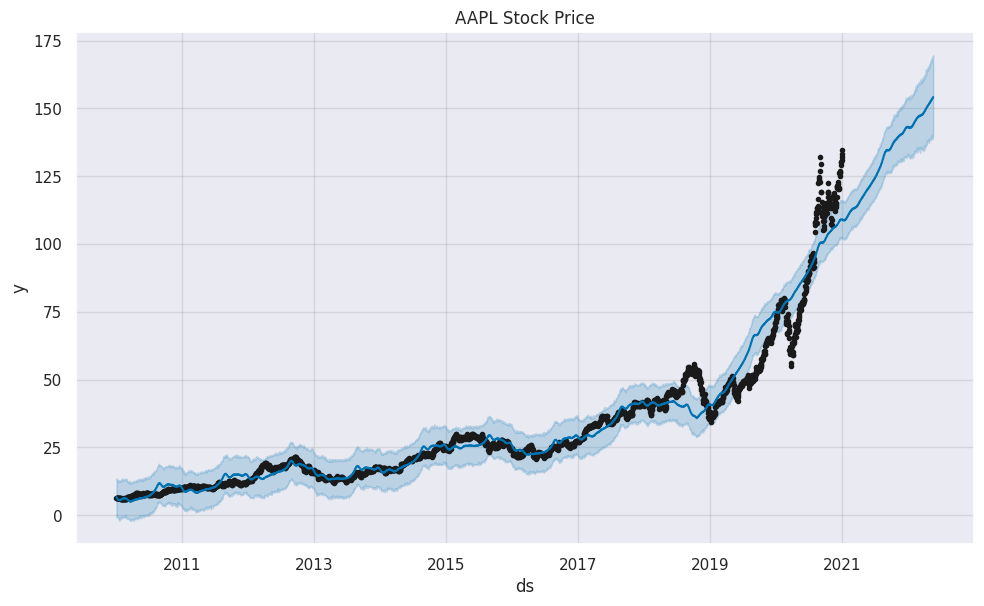

In [27]:
prices_model.plot(prices_predictions_df)
plt.title('AAPL Stock Price')
plt.show()

 Apple went public on December 12, 1980, with an initial public offering (IPO) price of $22 per share. In the following years, the stock price fluctuated, influenced by various factors such as product launches, financial performance, and market conditions. The price started to increase over the years, however Apple's stock price was not immune to the effects of the global financial crisis in 2008. Following the recession, Apple's stock price embarked on a period of consistent growth. Fluctuations in the price can be justified also because Apple has undergone multiple stock splits throughout its history. Notable splits include a 2-for-1 split in 2000, a 7-for-1 split in 2014, and a 4-for-1 split in 2020. These splits increased the number of shares outstanding and reduced the stock price accordingly, making it more accessible to a wider range of investors.

In the plot above:

*   black dots represent actual measurements
*   blue line displays Prophet’s forecast
*   light blue window indicates uncertainty intervals


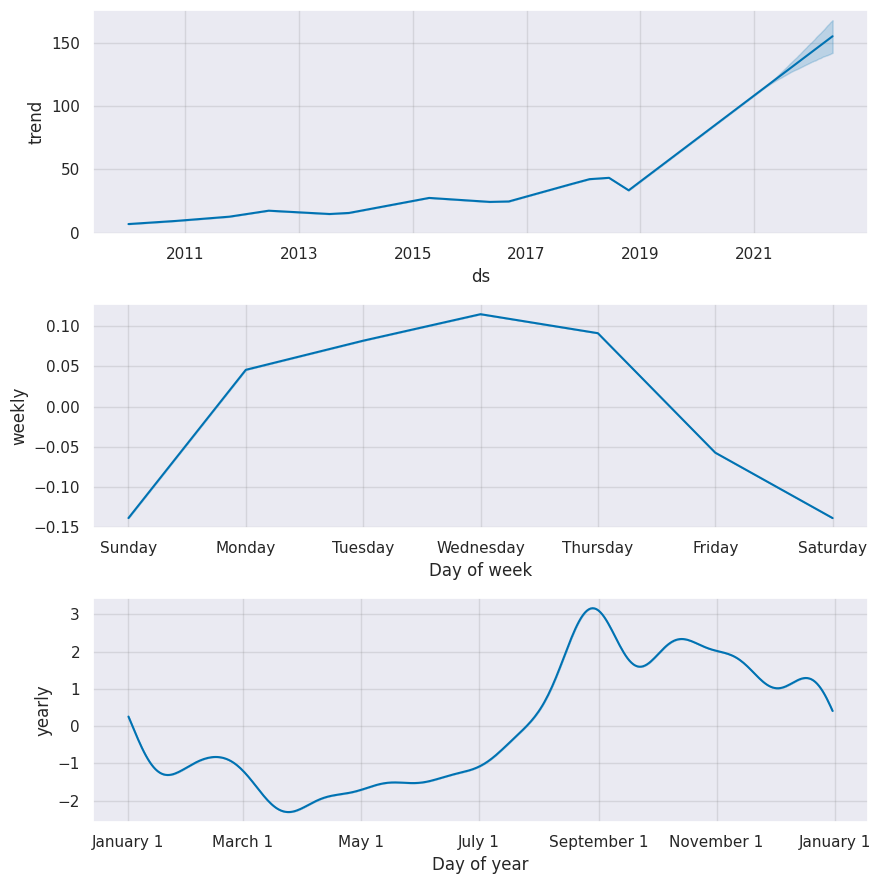

In [28]:
prices_model.plot_components(prices_predictions_df)
plt.show()

**Actual Weekly Seasonality**

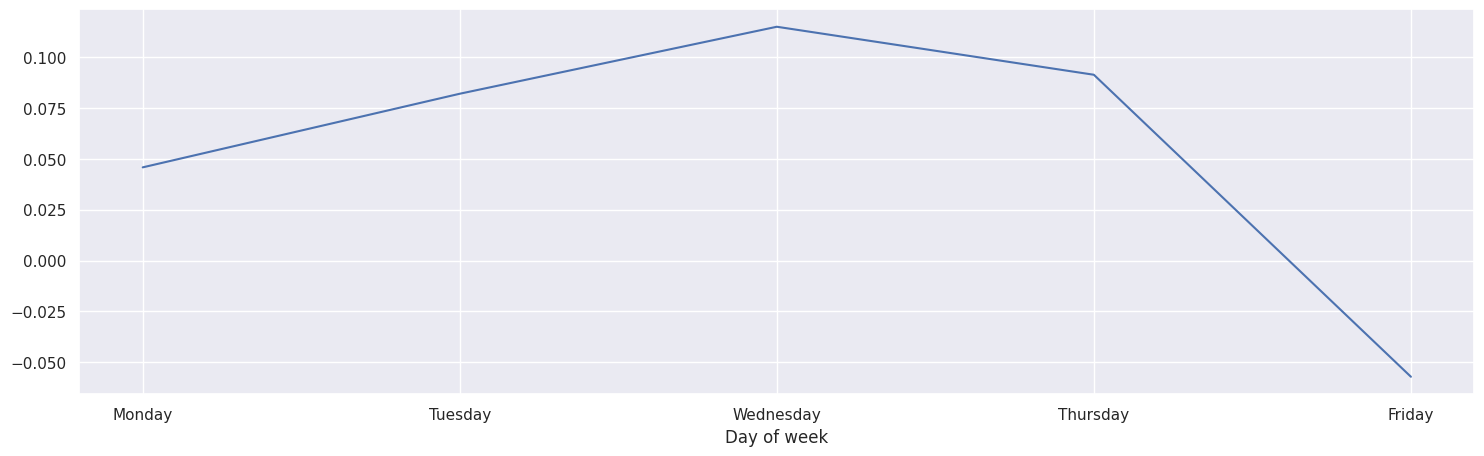

In [29]:
start_weekday = 0
while(True):
  if prices_predictions_df.ds[start_weekday].weekday() == 0:
    break
  else:
    start_weekday = start_weekday + 1

end_weekday = start_weekday + 5

days = prices_predictions_df.ds[start_weekday:end_weekday]
weekly_seas = prices_predictions_df.weekly[start_weekday:end_weekday]

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(np.arange(5), weekly_seas)
ax.set_xticks(np.arange(5))
ax.set_xticklabels(days.dt.day_name())
ax.set_xlabel('Day of week')

plt.show()

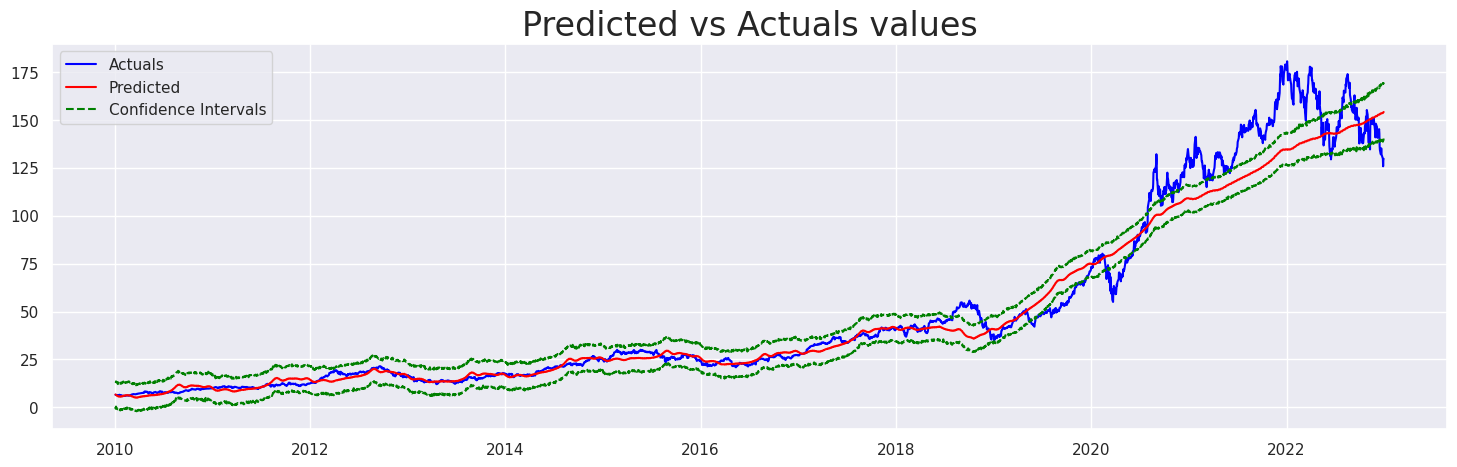

In [30]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(data["Adj Close"], color = "blue", label = "Actuals")
plt.plot(data.index, prices_predictions_df["yhat"], color = "red", label = "Predicted")
plt.plot(data.index, prices_predictions_df["yhat_lower"], color = "green", linestyle = "--", label = "Confidence Intervals")
plt.plot(data.index, prices_predictions_df["yhat_upper"], color = "green", linestyle = "--")

plt.title("Predicted vs Actuals values", size = 24)

plt.legend()
plt.show()

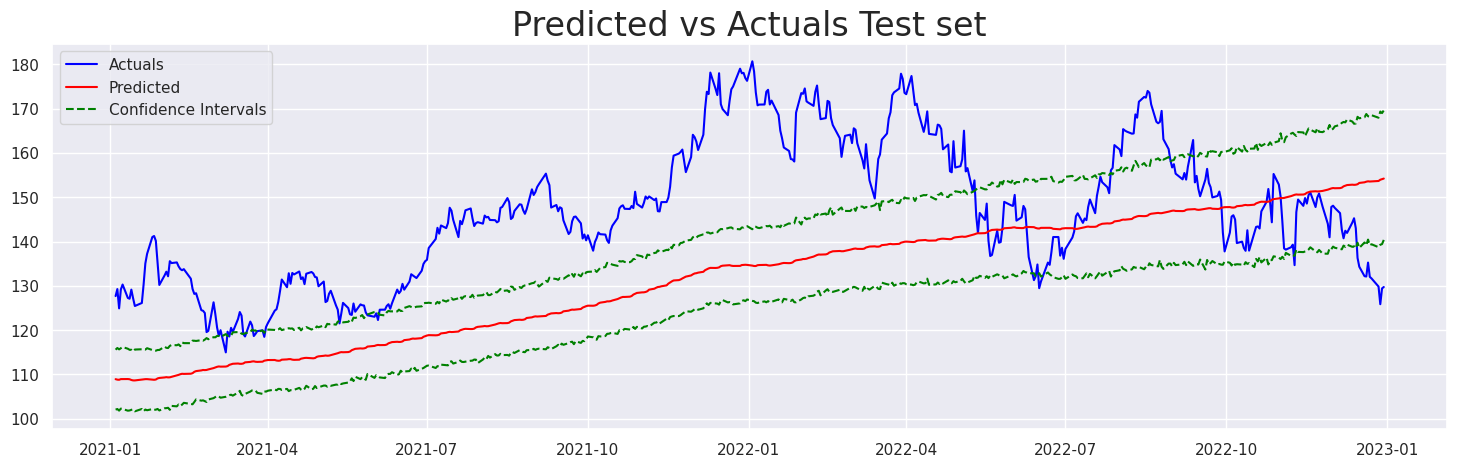

In [31]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(test_df["Adj Close"], color = "blue", label = "Actuals")
plt.plot(test_df.index, prices_predictions_df.loc[prices_train_df.index[-1]+1:]["yhat"], color = "red", label = "Predicted")
plt.plot(test_df.index, prices_predictions_df.loc[prices_train_df.index[-1]+1:]["yhat_lower"], color = "green", linestyle = "--", label = "Confidence Intervals")
plt.plot(test_df.index, prices_predictions_df.loc[prices_train_df.index[-1]+1:]["yhat_upper"], color = "green", linestyle = "--")

plt.title("Predicted vs Actuals Test set", size = 24)

plt.legend()
plt.show()

### Accuracy

In [32]:
y_true = prices_test_df["y"].values
y_pred = prices_predictions_df["yhat"][-len(prices_test_df.index):].values

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print("RMSE:", rmse)

RMSE: 20.700636226996508


### Cross-validation

In [33]:
df_cv_prices = cross_validation(prices_model, initial='2768 days', period='90 days', horizon = '14 days')
df_cv_prices.head()
df_cv_prices.tail()

INFO:prophet:Making 14 forecasts with cutoffs between 2017-10-04 00:00:00 and 2020-12-17 00:00:00


  0%|          | 0/14 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqsy8jcv/won_wibc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqsy8jcv/mj3nn6cf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23192', 'data', 'file=/tmp/tmpoqsy8jcv/won_wibc.json', 'init=/tmp/tmpoqsy8jcv/mj3nn6cf.json', 'output', 'file=/tmp/tmpoqsy8jcv/prophet_model186a2owm/prophet_model-20230525072353.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:23:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:23:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqsy8jcv/qxwae1w5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqsy8jcv/fn_npn14.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
127,2020-12-24,105.188463,98.381655,112.349774,130.205780,2020-12-17
128,2020-12-28,105.111680,98.028853,112.056694,134.862671,2020-12-17
129,2020-12-29,105.170777,98.699062,112.133212,133.067001,2020-12-17
130,2020-12-30,105.223936,98.237037,112.300718,131.932388,2020-12-17
131,2020-12-31,105.248154,97.941804,112.343172,130.916138,2020-12-17


In [34]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv_prices)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,2 days,50.588076,7.112530,4.221412,0.063024,0.046575,0.065609,0.461538
1,3 days,107.048843,10.346441,7.405888,0.110299,0.052589,0.114237,0.290598
2,4 days,163.067655,12.769795,9.740899,0.123849,0.099537,0.132266,0.299145
3,5 days,151.558834,12.310923,8.733506,0.110123,0.090198,0.114382,0.461538
4,6 days,144.605979,12.025223,8.450683,0.117411,0.075796,0.116464,0.423077
5,7 days,158.747416,12.599501,8.792718,0.124126,0.091921,0.124591,0.400000
6,8 days,88.382801,9.401213,5.426167,0.081014,0.027316,0.084030,0.538462
7,9 days,43.741121,6.613707,3.556780,0.055108,0.023000,0.058480,0.576923
8,10 days,137.776233,11.737812,8.286582,0.125091,0.084664,0.128177,0.282051
9,11 days,223.146645,14.938094,11.033762,0.145890,0.212244,0.150904,0.276923


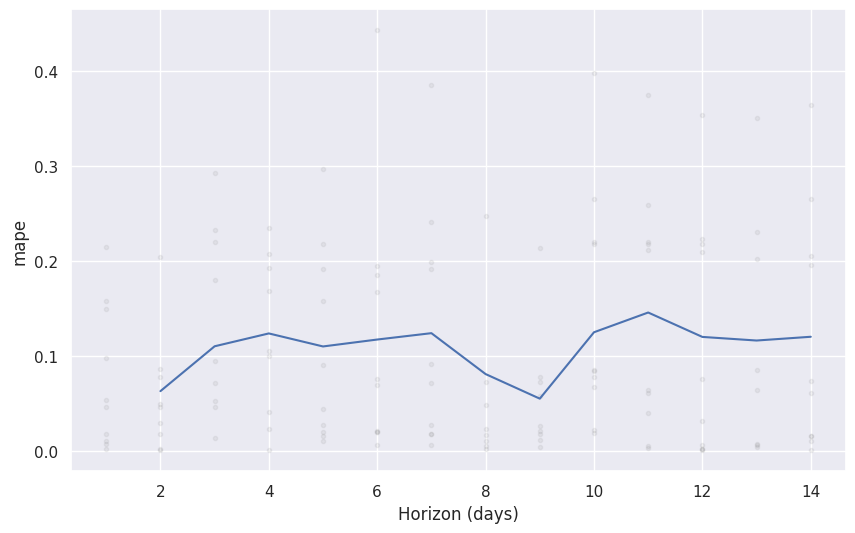

In [35]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv_prices, metric = 'mape')

### Conclusion
In this notebook, FB Prophet is used to investigate log returns and adjusted prices of AAPL stock. In particular, we observe that Prophet does pretty well when dealing with log returns, which are almst scattered around zero, whereas when using Adjusted Close prices, it is able to capture the increasing trend, however it is less accurate as confirmed by the metrics. Parameter grid is not included in this notebbok, however it has been performed behind the scene, without improving too much the results but increasingly the computational complexity of the model. Moreover, in order to improve the performance of the model, one has to provide to Prophet more information about seasonality, growth and holidays or special events that impacted the firm.